In [1]:
import pathlib, os
if 'TSL_SCHOOL_DIR' in os.environ:
    assert not any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ),\
                     'Please copy notebook to a work directory'

## How accurately can we calculate thermal systems?

This question was presented almost two decades ago by Red Cullen and led to a very interesting exercise to compare thermal treatment in different radiation transport codes, using as numerical benchmark a simplified reactor fuel pin cell and [published by the IAEA](https://nds.iaea.org/publications/indc/indc-usa-0107.pdf). This study was continued with an analysis of thermalization of point sources in water (published [here](https://doi.org/10.2172/889442)) which resulted in a improvement of the thermal treatment in Monte Carlo codes.

For this example we will continue studying this question by making a numerical exercise, similar to the second analysis:

- A 30 cm-radius sphere.

- Filled with water defined as 2 atoms of H-1 and 1 atom of O16, at room temperature (T = 293.6 K), with density 1 g/cm3.

- Use ENDF/B-VIII.0 data (OpenMC nuclear data libraries).

- Use TART 616 energy bins (50 bins per decade, from 1e-5 eV to 20 MeV).

- Tally both scalar flux within the sphere, and leakage (scalar current) leaking from the surface of the sphere.



We will use this example to make a self-consistency test. If we approximate both H1 and O16 with a free gas model, we can benchmark the results against the simulations using the collision kinematics model included in Monte Carlo. So, we will define the following cases:

1) H1 and O16 modelled with the internal collision kinematics model (OpenMC material without $S(\alpha, \beta)$).

2) H1 and O16 modelled with the free gas model in NCrystal (NCrystal sampling the $S(\alpha, \beta)$ for a free gas computed with NCrystal).

3) H1 scattering kernel for a free gas computed with NJOY using LEAPR / THERMR / ACER and imported into OpenMC. O16 modelled with the internal collision kinematics model.

4) H1 scattering kernel for a free gas computed with LEAPR, and imported into NCrystal using `set_dyninfo_scatknl()` (NCrystal sampling the $S(\alpha, \beta)$ for a free gas computed with LEAPR).


In [2]:
import openmc
import openmc.data
import numpy as np
import matplotlib.pyplot as plt
import NCrystal as NC

openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

### Defic

Define the TART 616 energy group structure.

In [3]:
txt = """
1.000000e-05 1.047130e-05 1.096480e-05 1.148150e-05 1.202260e-05 1.258930e-05 1.318260e-05 1.380380e-05 
1.445440e-05 1.513560e-05 1.584890e-05 1.659590e-05 1.737800e-05 1.819700e-05 1.905460e-05 1.995260e-05 
2.089300e-05 2.187760e-05 2.290870e-05 2.398830e-05 2.511890e-05 2.630270e-05 2.754230e-05 2.884030e-05 
3.019950e-05 3.162280e-05 3.311310e-05 3.467370e-05 3.630780e-05 3.801890e-05 3.981070e-05 4.168690e-05 
4.365160e-05 4.570880e-05 4.786300e-05 5.011870e-05 5.248070e-05 5.495410e-05 5.754400e-05 6.025600e-05 
6.309570e-05 6.606930e-05 6.918310e-05 7.244360e-05 7.585780e-05 7.943280e-05 8.317640e-05 8.709640e-05 
9.120110e-05 9.549930e-05 1.000000e-04 1.047130e-04 1.096480e-04 1.148150e-04 1.202260e-04 1.258930e-04 
1.318260e-04 1.380380e-04 1.445440e-04 1.513560e-04 1.584890e-04 1.659590e-04 1.737800e-04 1.819700e-04 
1.905460e-04 1.995260e-04 2.089300e-04 2.187760e-04 2.290870e-04 2.398830e-04 2.511890e-04 2.630270e-04 
2.754230e-04 2.884030e-04 3.019950e-04 3.162280e-04 3.311310e-04 3.467370e-04 3.630780e-04 3.801890e-04 
3.981070e-04 4.168690e-04 4.365160e-04 4.570880e-04 4.786300e-04 5.011870e-04 5.248070e-04 5.495410e-04 
5.754400e-04 6.025600e-04 6.309570e-04 6.606930e-04 6.918310e-04 7.244360e-04 7.585780e-04 7.943280e-04 
8.317640e-04 8.709640e-04 9.120110e-04 9.549930e-04 1.000000e-03 1.047130e-03 1.096480e-03 1.148150e-03 
1.202260e-03 1.258930e-03 1.318260e-03 1.380380e-03 1.445440e-03 1.513560e-03 1.584890e-03 1.659590e-03 
1.737800e-03 1.819700e-03 1.905460e-03 1.995260e-03 2.089300e-03 2.187760e-03 2.290870e-03 2.398830e-03 
2.511890e-03 2.630270e-03 2.754230e-03 2.884030e-03 3.019950e-03 3.162280e-03 3.311310e-03 3.467370e-03 
3.630780e-03 3.801890e-03 3.981070e-03 4.168690e-03 4.365160e-03 4.570880e-03 4.786300e-03 5.011870e-03 
5.248070e-03 5.495410e-03 5.754400e-03 6.025600e-03 6.309570e-03 6.606930e-03 6.918310e-03 7.244360e-03 
7.585780e-03 7.943280e-03 8.317640e-03 8.709640e-03 9.120110e-03 9.549930e-03 1.000000e-02 1.047130e-02 
1.096480e-02 1.148150e-02 1.202260e-02 1.258930e-02 1.318260e-02 1.380380e-02 1.445440e-02 1.513560e-02 
1.584890e-02 1.659590e-02 1.737800e-02 1.819700e-02 1.905460e-02 1.995260e-02 2.089300e-02 2.187760e-02 
2.290870e-02 2.398830e-02 2.511890e-02 2.630270e-02 2.754230e-02 2.884030e-02 3.019950e-02 3.162280e-02 
3.311310e-02 3.467370e-02 3.630780e-02 3.801890e-02 3.981070e-02 4.168690e-02 4.365160e-02 4.570880e-02 
4.786300e-02 5.011870e-02 5.248070e-02 5.495410e-02 5.754400e-02 6.025600e-02 6.309570e-02 6.606930e-02 
6.918310e-02 7.244360e-02 7.585780e-02 7.943280e-02 8.317640e-02 8.709640e-02 9.120110e-02 9.549930e-02 
1.000000e-01 1.047130e-01 1.096480e-01 1.148150e-01 1.202260e-01 1.258930e-01 1.318260e-01 1.380380e-01 
1.445440e-01 1.513560e-01 1.584890e-01 1.659590e-01 1.737800e-01 1.819700e-01 1.905460e-01 1.995260e-01 
2.089300e-01 2.187760e-01 2.290870e-01 2.398830e-01 2.511890e-01 2.630270e-01 2.754230e-01 2.884030e-01 
3.019950e-01 3.162280e-01 3.311310e-01 3.467370e-01 3.630780e-01 3.801890e-01 3.981070e-01 4.168690e-01 
4.365160e-01 4.570880e-01 4.786300e-01 5.011870e-01 5.248070e-01 5.495410e-01 5.754400e-01 6.025600e-01 
6.309570e-01 6.606930e-01 6.918310e-01 7.244360e-01 7.585780e-01 7.943280e-01 8.317640e-01 8.709640e-01 
9.120110e-01 9.549930e-01 1.000000e+00 1.047130e+00 1.096480e+00 1.148150e+00 1.202260e+00 1.258930e+00 
1.318260e+00 1.380380e+00 1.445440e+00 1.513560e+00 1.584890e+00 1.659590e+00 1.737800e+00 1.819700e+00 
1.905460e+00 1.995260e+00 2.089300e+00 2.187760e+00 2.290870e+00 2.398830e+00 2.511890e+00 2.630270e+00 
2.754230e+00 2.884030e+00 3.019950e+00 3.162280e+00 3.311310e+00 3.467370e+00 3.630780e+00 3.801890e+00 
3.981070e+00 4.168690e+00 4.365160e+00 4.570880e+00 4.786300e+00 5.011870e+00 5.248070e+00 5.495410e+00 
5.754400e+00 6.025600e+00 6.309570e+00 6.606930e+00 6.918310e+00 7.244360e+00 7.585780e+00 7.943280e+00 
8.317640e+00 8.709640e+00 9.120110e+00 9.549930e+00 1.000000e+01 1.047130e+01 1.096480e+01 1.148150e+01 
1.202260e+01 1.258930e+01 1.318260e+01 1.380380e+01 1.445440e+01 1.513560e+01 1.584890e+01 1.659590e+01 
1.737800e+01 1.819700e+01 1.905460e+01 1.995260e+01 2.089300e+01 2.187760e+01 2.290870e+01 2.398830e+01 
2.511890e+01 2.630270e+01 2.754230e+01 2.884030e+01 3.019950e+01 3.162280e+01 3.311310e+01 3.467370e+01 
3.630780e+01 3.801890e+01 3.981070e+01 4.168690e+01 4.365160e+01 4.570880e+01 4.786300e+01 5.011870e+01 
5.248070e+01 5.495410e+01 5.754400e+01 6.025600e+01 6.309570e+01 6.606930e+01 6.918310e+01 7.244360e+01 
7.585780e+01 7.943280e+01 8.317640e+01 8.709640e+01 9.120110e+01 9.549930e+01 1.000000e+02 1.047130e+02 
1.096480e+02 1.148150e+02 1.202260e+02 1.258930e+02 1.318260e+02 1.380380e+02 1.445440e+02 1.513560e+02 
1.584890e+02 1.659590e+02 1.737800e+02 1.819700e+02 1.905460e+02 1.995260e+02 2.089300e+02 2.187760e+02 
2.290870e+02 2.398830e+02 2.511890e+02 2.630270e+02 2.754230e+02 2.884030e+02 3.019950e+02 3.162280e+02 
3.311310e+02 3.467370e+02 3.630780e+02 3.801890e+02 3.981070e+02 4.168690e+02 4.365160e+02 4.570880e+02 
4.786300e+02 5.011870e+02 5.248070e+02 5.495410e+02 5.754400e+02 6.025600e+02 6.309570e+02 6.606930e+02 
6.918310e+02 7.244360e+02 7.585780e+02 7.943280e+02 8.317640e+02 8.709640e+02 9.120110e+02 9.549930e+02 
1.000000e+03 1.047130e+03 1.096480e+03 1.148150e+03 1.202260e+03 1.258930e+03 1.318260e+03 1.380380e+03 
1.445440e+03 1.513560e+03 1.584890e+03 1.659590e+03 1.737800e+03 1.819700e+03 1.905460e+03 1.995260e+03 
2.089300e+03 2.187760e+03 2.290870e+03 2.398830e+03 2.511890e+03 2.630270e+03 2.754230e+03 2.884030e+03 
3.019950e+03 3.162280e+03 3.311310e+03 3.467370e+03 3.630780e+03 3.801890e+03 3.981070e+03 4.168690e+03 
4.365160e+03 4.570880e+03 4.786300e+03 5.011870e+03 5.248070e+03 5.495410e+03 5.754400e+03 6.025600e+03 
6.309570e+03 6.606930e+03 6.918310e+03 7.244360e+03 7.585780e+03 7.943280e+03 8.317640e+03 8.709640e+03 
9.120110e+03 9.549930e+03 1.000000e+04 1.047130e+04 1.096480e+04 1.148150e+04 1.202260e+04 1.258930e+04 
1.318260e+04 1.380380e+04 1.445440e+04 1.513560e+04 1.584890e+04 1.659590e+04 1.737800e+04 1.819700e+04 
1.905460e+04 1.995260e+04 2.089300e+04 2.187760e+04 2.290870e+04 2.398830e+04 2.511890e+04 2.630270e+04 
2.754230e+04 2.884030e+04 3.019950e+04 3.162280e+04 3.311310e+04 3.467370e+04 3.630780e+04 3.801890e+04 
3.981070e+04 4.168690e+04 4.365160e+04 4.570880e+04 4.786300e+04 5.011870e+04 5.248070e+04 5.495410e+04 
5.754400e+04 6.025600e+04 6.309570e+04 6.606930e+04 6.918310e+04 7.244360e+04 7.585780e+04 7.943280e+04 
8.317640e+04 8.709640e+04 9.120110e+04 9.549930e+04 1.000000e+05 1.047130e+05 1.096480e+05 1.148150e+05 
1.202260e+05 1.258930e+05 1.318260e+05 1.380380e+05 1.445440e+05 1.513560e+05 1.584890e+05 1.659590e+05 
1.737800e+05 1.819700e+05 1.905460e+05 1.995260e+05 2.089300e+05 2.187760e+05 2.290870e+05 2.398830e+05 
2.511890e+05 2.630270e+05 2.754230e+05 2.884030e+05 3.019950e+05 3.162280e+05 3.311310e+05 3.467370e+05 
3.630780e+05 3.801890e+05 3.981070e+05 4.168690e+05 4.365160e+05 4.570880e+05 4.786300e+05 5.011870e+05 
5.248070e+05 5.495410e+05 5.754400e+05 6.025600e+05 6.309570e+05 6.606930e+05 6.918310e+05 7.244360e+05 
7.585780e+05 7.943280e+05 8.317640e+05 8.709640e+05 9.120110e+05 9.549930e+05 1.000000e+06 1.047130e+06 
1.096480e+06 1.148150e+06 1.202260e+06 1.258930e+06 1.318260e+06 1.380380e+06 1.445440e+06 1.513560e+06 
1.584890e+06 1.659590e+06 1.737800e+06 1.819700e+06 1.905460e+06 1.995260e+06 2.089300e+06 2.187760e+06 
2.290870e+06 2.398830e+06 2.511890e+06 2.630270e+06 2.754230e+06 2.884030e+06 3.019950e+06 3.162280e+06 
3.311310e+06 3.467370e+06 3.630780e+06 3.801890e+06 3.981070e+06 4.168690e+06 4.365160e+06 4.570880e+06 
4.786300e+06 5.011870e+06 5.248070e+06 5.495410e+06 5.754400e+06 6.025600e+06 6.309570e+06 6.606930e+06 
6.918310e+06 7.244360e+06 7.585780e+06 7.943280e+06 8.317640e+06 8.709640e+06 9.120110e+06 9.549930e+06 
1.000000e+07 1.047130e+07 1.096480e+07 1.148150e+07 1.202260e+07 1.258930e+07 1.318260e+07 1.380380e+07 
1.445440e+07 1.513560e+07 1.584890e+07 1.659590e+07 1.737800e+07 1.819700e+07 1.905460e+07 1.995260e+07 
2.000000e+07 
"""
tart_groups = np.fromstring(txt, sep=' ')

Define a function to create a model: 30 cm sphere with an isotropic, 14.1 MeV source, and functions to extract the tallies:

In [4]:
def create_model(mod_mat, NParticles=100000, E0=14.1e+6):
    s1 = openmc.Sphere(r=30)
    s99 = openmc.Sphere(r=100, boundary_type='vacuum')
    c1 = openmc.Cell(region=-s1, fill=mod_mat)
    c99 = openmc.Cell(region=+s1&-s99, fill=None)
    u1 = openmc.Universe(cells=[c1, c99])
    geometry = openmc.Geometry(root=u1)
    
    source = openmc.Source()
    source.energy = openmc.stats.Discrete([E0], [1.0])
    
    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter11 = openmc.CellFilter([c1])
    filter12 = openmc.EnergyFilter(tart_groups)
    tally1.scores = ['flux']
    tally1.name = 'spectrum'
    tally1.filters = [filter11, filter12]
    
    tally2 = openmc.Tally()
    filter21 = openmc.SurfaceFilter([s1])
    filter22 = openmc.CellFromFilter([c1])
    filter23 = openmc.CellFilter([c99])
    tally2.scores = ['current']
    tally2.name = 'leakage spectrum'
    tally2.filters = [filter21, filter22, filter23, filter12]

    tallies = openmc.Tallies([tally1, tally2])
    
    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

def get_tally(spfile='statepoint.10.h5'):
    sp = openmc.StatePoint(spfile)
    tally = sp.get_tally(name='spectrum')
    df = tally.get_pandas_dataframe()
    phi_g = df['mean'].values
    E_g = df['energy high [eV]'].values
    return E_g, phi_g

def get_surface_tally(spfile='statepoint.10.h5'):
    sp = openmc.StatePoint(spfile)
    tally = sp.get_tally(name='leakage spectrum')
    df = tally.get_pandas_dataframe()
    phi_g = df['mean'].values
    E_g = df['energy high [eV]'].values
    return E_g, phi_g

### Case 1: OpenMC material without $S(\alpha, \beta)$ table:

In [5]:
mat_openmc = openmc.Material()
mat_openmc.add_nuclide('H1', 2.0, 'ao')
mat_openmc.add_nuclide('O16', 1.0, 'ao')
mat_openmc.set_density('g/cm3', 1.0)
mat_openmc.temperature = 293.6 # K

model = create_model(mat_openmc)
model.export_to_xml()

In [6]:
!rm summary.h5 statepoint.10.h5
openmc.run()
E1, phi1 = get_tally()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [7]:
Es1, phis1 = get_surface_tally()

### Case 2: NCrystal material. 

We save it as an NCMAT file to later replace the dynamical information.

In [8]:
c=NC.NCMATComposer('freegas::H2O/1.0gcm3/H_is_H1/O_is_O16;temp=293.6K')
c.write('free_h2o.ncmat')
mat_ncrystal = openmc.Material.from_ncrystal('free_h2o.ncmat')
model = create_model(mat_ncrystal)
model.export_to_xml()

In [9]:
!rm summary.h5 statepoint.10.h5
openmc.run()
E2, phi2 = get_tally()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

### Case 3: scattering kernel for a free gas model, computed with NJOY and imported into OpenMC.

We start by downloading the ENDF file for H-1 from the [IAEA Nuclear Data Section archive](https://www-nds.iaea.org/public/download-endf):

In [10]:
url = 'https://www-nds.iaea.org/public/download-endf/JEFF-3.3/n/n_0125_1-H-1.zip'
user_agent = '--user-agent="Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0"'
zipfile = 'file.zip'
endffile = url.split('/')[-1].replace('zip', 'dat')
acefile = url.split('/')[-1].replace('zip', 'ace')

a = os.system(f'wget --quiet -O {zipfile} {user_agent} "{url}"')
a = os.system(f'unzip -o {zipfile}')

Archive:  file.zip
  inflating: n_0125_1-H-1.dat        


Define NJOY input:

In [11]:
txt = f"""
 moder
 30 -31
 reconr
 -31 -32
 'pendf tape for h-1 from jeff-3.3'/
 125 3/
 .001/
 '1-h-1 from jeff-3.3'/
 ''/
 ''/
 0/
 broadr
 -31 -32 -33
 125 1/
 .001/
 293.6
 0/
leapr
34  /NOUT
H as free gas / TITLE
1 2 200  / NTEMPR IPRINT IPHON
1 1001 0 0 1.00e-300 -600.00 / MAT ZA ISABT ILOG
0.9991673 20.43608 1 0 0 0  / AWR SPR NPR IEL NCOLD NSK
0 / NSS B7 AWS SPS MSS
182 259 0 / NALPHA NBETA LAT
4.9958e-04 9.9915e-04 4.9958e-03 9.9915e-03 2.4979e-02 
4.9958e-02 7.4936e-02 9.9915e-02 1.2489e-01 1.4987e-01 
1.9983e-01 2.4979e-01 2.9974e-01 3.2472e-01 3.4970e-01 
3.7468e-01 3.9966e-01 4.2464e-01 4.4962e-01 4.7460e-01 
4.9957e-01 5.2455e-01 5.4953e-01 5.7951e-01 6.0948e-01 
6.4945e-01 6.8941e-01 7.2938e-01 7.7934e-01 8.2930e-01 
8.7925e-01 9.3920e-01 9.9915e-01 1.0791e+00 1.1590e+00 
1.2389e+00 1.3289e+00 1.4288e+00 1.5387e+00 1.6586e+00 
1.7885e+00 1.9384e+00 2.0882e+00 2.2581e+00 2.4779e+00 
2.7104e+00 2.8876e+00 3.1074e+00 3.3771e+00 3.6669e+00 
3.9766e+00 4.3163e+00 4.6460e+00 4.9958e+00 5.4209e+00 
5.9949e+00 6.5544e+00 7.1239e+00 7.5935e+00 8.0957e+00 
8.7925e+00 9.4919e+00 1.0191e+01 1.0806e+01 1.1690e+01 
1.2589e+01 1.3517e+01 1.4388e+01 1.5287e+01 1.6191e+01 
1.7218e+01 1.8184e+01 1.8904e+01 2.0283e+01 2.1612e+01 
2.2881e+01 2.4287e+01 2.5578e+01 2.6997e+01 2.8376e+01 
2.9705e+01 3.0974e+01 3.2383e+01 3.3412e+01 3.4437e+01 
3.6119e+01 3.7148e+01 3.8767e+01 4.0479e+01 4.1505e+01 
4.2534e+01 4.4163e+01 4.5961e+01 4.6960e+01 4.8574e+01 
4.9558e+01 5.1157e+01 5.2455e+01 5.4364e+01 5.5153e+01 
5.6672e+01 5.8350e+01 5.9749e+01 6.1148e+01 6.2457e+01 
6.3746e+01 6.5175e+01 6.6444e+01 6.7842e+01 6.8871e+01 
7.0550e+01 7.1579e+01 7.2858e+01 7.5836e+01 7.9932e+01 
8.3929e+01 8.8924e+01 9.3920e+01 9.9915e+01 1.0491e+02 
1.1290e+02 1.2053e+02 1.2589e+02 1.3189e+02 1.3988e+02 
1.4688e+02 1.5387e+02 1.6186e+02 1.6986e+02 1.7685e+02 
1.8384e+02 1.9084e+02 1.9883e+02 2.0782e+02 2.1781e+02 
2.2681e+02 2.3680e+02 2.4579e+02 2.5478e+02 2.6477e+02 
2.7549e+02 2.8376e+02 2.9333e+02 3.0174e+02 3.1074e+02 
3.1973e+02 3.2872e+02 3.3771e+02 3.4670e+02 3.5570e+02 
3.6469e+02 3.7368e+02 3.8268e+02 3.9167e+02 4.0066e+02 
4.0965e+02 4.1864e+02 4.2764e+02 4.3663e+02 4.4562e+02 
4.5461e+02 4.6361e+02 4.7260e+02 4.8159e+02 4.9058e+02 
4.9957e+02 5.0857e+02 5.1756e+02 5.2655e+02 5.3554e+02 
5.4454e+02 5.5353e+02 5.6252e+02 5.7151e+02 5.8051e+02 
5.8950e+02 5.9649e+02 6.0349e+02 6.1048e+02 6.1748e+02 
6.2447e+02 6.3236e+02   /   end of alpha grid
0.0000e+00 4.9999e-03 9.9998e-03 2.5000e-02 4.9999e-02 
7.4999e-02 9.9998e-02 1.5000e-01 2.0000e-01 2.4999e-01 
2.9999e-01 3.4999e-01 3.9999e-01 4.4999e-01 4.9999e-01 
5.4999e-01 5.9999e-01 6.4999e-01 6.9999e-01 7.4999e-01 
7.9998e-01 8.4998e-01 8.9998e-01 9.4998e-01 9.9998e-01 
1.0500e+00 1.1000e+00 1.1500e+00 1.2000e+00 1.2500e+00 
1.3000e+00 1.3500e+00 1.4000e+00 1.4500e+00 1.5000e+00 
1.5500e+00 1.6000e+00 1.6500e+00 1.7000e+00 1.7500e+00 
1.8000e+00 1.8500e+00 1.9000e+00 1.9500e+00 2.0000e+00 
2.0500e+00 2.1000e+00 2.1500e+00 2.2000e+00 2.2500e+00 
2.3000e+00 2.3500e+00 2.4000e+00 2.4499e+00 2.5000e+00 
2.5499e+00 2.6000e+00 2.6500e+00 2.7127e+00 2.7700e+00 
2.8300e+00 2.8999e+00 2.9599e+00 3.0299e+00 3.1099e+00 
3.1799e+00 3.2599e+00 3.3399e+00 3.4299e+00 3.5199e+00 
3.6099e+00 3.7099e+00 3.8099e+00 3.9199e+00 4.0299e+00 
4.1399e+00 4.2599e+00 4.3899e+00 4.5199e+00 4.6499e+00 
4.7999e+00 4.9399e+00 5.0999e+00 5.2599e+00 5.4254e+00 
5.5999e+00 5.7799e+00 5.9699e+00 6.1699e+00 6.3699e+00 
6.5899e+00 6.8099e+00 7.0399e+00 7.2899e+00 7.5399e+00 
7.8098e+00 8.1029e+00 8.3698e+00 8.6698e+00 8.9798e+00 
9.2998e+00 9.6398e+00 9.9998e+00 1.0400e+01 1.0815e+01 
1.1160e+01 1.1570e+01 1.2000e+01 1.2460e+01 1.2980e+01 
1.3528e+01 1.3940e+01 1.4480e+01 1.5030e+01 1.5620e+01 
1.6205e+01 1.6800e+01 1.7233e+01 1.8200e+01 1.8920e+01 
1.9400e+01 1.9950e+01 2.0700e+01 2.1630e+01 2.2100e+01 
2.2660e+01 2.3500e+01 2.4308e+01 2.4799e+01 2.5340e+01 
2.6200e+01 2.7020e+01 2.7500e+01 2.8049e+01 2.8899e+01 
2.9729e+01 3.0199e+01 3.0759e+01 3.1499e+01 3.2409e+01 
3.2899e+01 3.3439e+01 3.3999e+01 3.4465e+01 3.5299e+01 
3.6149e+01 3.6599e+01 3.7179e+01 3.7899e+01 3.8799e+01 
3.9889e+01 4.0199e+01 4.0512e+01 4.0999e+01 4.1539e+01 
4.1999e+01 4.2569e+01 4.3199e+01 4.4199e+01 4.5279e+01 
4.5999e+01 4.6999e+01 4.7989e+01 4.8299e+01 4.8614e+01 
4.9599e+01 5.0669e+01 5.1199e+01 5.1699e+01 5.2499e+01 
5.3379e+01 5.3899e+01 5.4409e+01 5.5199e+01 5.5999e+01 
5.6719e+01 5.7119e+01 5.8399e+01 5.9799e+01 6.1199e+01 
6.2509e+01 6.3799e+01 6.5229e+01 6.6499e+01 6.7899e+01 
6.8399e+01 6.8929e+01 6.9799e+01 7.0609e+01 7.1099e+01 
7.1639e+01 7.2199e+01 7.2919e+01 7.3333e+01 7.3999e+01 
7.4799e+01 7.5599e+01 7.6398e+01 7.7198e+01 7.7999e+01 
7.8898e+01 7.9799e+01 8.0698e+01 8.1598e+01 8.2498e+01 
8.3398e+01 8.4298e+01 8.5198e+01 8.6098e+01 8.6998e+01 
8.7998e+01 8.8998e+01 8.9998e+01 9.0998e+01 9.1998e+01 
9.2998e+01 9.3998e+01 9.4998e+01 9.5998e+01 9.6998e+01 
9.7998e+01 9.8998e+01 9.9998e+01 1.0120e+02 1.0240e+02 
1.0360e+02 1.0480e+02 1.0600e+02 1.0720e+02 1.0840e+02 
1.0960e+02 1.1080e+02 1.1200e+02 1.1350e+02 1.1500e+02 
1.1650e+02 1.1800e+02 1.1950e+02 1.2100e+02 1.2250e+02 
1.2400e+02 1.2550e+02 1.2700e+02 1.2850e+02 1.3000e+02 
1.3200e+02 1.3400e+02 1.3600e+02 1.3800e+02 1.4000e+02 
1.4200e+02 1.4400e+02 1.4600e+02 1.4800e+02 1.5000e+02 
1.5200e+02 1.5400e+02 1.5600e+02 1.5810e+02  / end of beta grid
293.6  /    temperature (K)   
0.001 2 /    frequency distribution: DELTA NI  
0.0000e+00 1e-20  / end of spectrum
1.0 0.0 1e-20/ TWT C TBETA  
0 / ND      
'H FREE GAS  ESS      EVAL-                                      '
'                      DIST-                                       '
'----ENDF/B-VIII.beta  MATERIAL 1                                  '
'-----THERMAL NEUTRON SCATTERING DATA                              '
'------ENDF-6 FORMAT                                               '
'                                                                  '
'******************************************************************'
'*                                                                *'
'* Temperatures = 293.6 K                                         *'
'*                                                                *'
'******************************************************************'
'                                                                  '

/ end leapr
 thermr
 34 -33 -35
 1 125 32 1 2 0 2 1 221 2
 293.6
 0.001 5.0 -600
 acer
 -31 -35 0 60 61  
 2 1 1 .01 0
'* H as free gas *'/
 125  293.6 hfree 3
 1001 0 0
 221 500 0 0 1 5.0 2
 stop
"""
with open('input', mode='w') as f:
    f.write(txt)

Run NJOY model:

In [12]:
a = os.system(f'cp {endffile} tape30')
a = os.system(f'njoy < input')
a = os.system(f'cp tape60 {acefile}')
a = os.system(f'cp tape34 tsl-H_free.endf')


 njoy 2016.62  09Mar21                                       05/21/23 22:31:28
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.0s

 broadr...                                                                0.0s

 leapr...                                                                 0.2s

 thermr...                                                                0.8s

 ***warning***maximum value of beta limits the allowed energy transfer
 the sct approx. will be used for transfers larger than  4.000 ev.

 wrote thermal data for temp = 2.9360E+02                                22.3s

 acer...                                                                 22.3s
                                                                         24.9s
 **************************************************************

Convert ACE file to HDF5 format for OpenMC:

In [13]:
!rm c_H_free.h5
data = openmc.data.ThermalScattering.from_ace(acefile, name='c_H_free')
data.export_to_hdf5('c_H_free.h5')

Copy to OpenMC library directory:

In [14]:
print ("Adding HDF5 to the nuclear data library...")
!cp c_H_free.h5 /home/student/tsl_software/endfb-viii.0-hdf5/

Adding HDF5 to the nuclear data library...


Add entry in `cross_sections.xml` (this is only needed once, if the file exists it will not be added again):

In [15]:
data_library = openmc.data.DataLibrary().from_xml(openmc.config['cross_sections'])
if not data_library.get_by_material('c_H_free', data_type='thermal'):
    print('Registering material..')
    data_library.register_file("./c_H_free.h5")
    data_library.export_to_xml(openmc.config['cross_sections'])

Create the model. Compare with case 1): the difference is `.add_s_alpha_beta('c_H_free')`.

In [16]:
mat_njoy = openmc.Material()
mat_njoy.add_nuclide('H1', 2.0, 'ao')
mat_njoy.add_nuclide('O16', 1.0, 'ao')
mat_njoy.set_density('g/cm3', 1.0)
mat_njoy.add_s_alpha_beta('c_H_free')
mat_njoy.temperature = 293.6 # K

model = create_model(mat_njoy)
model.export_to_xml()

In [17]:
!rm summary.h5 statepoint.10.h5
openmc.run()
E3, phi3 = get_tally()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

### Case 4: scattering kernel for a free gas computed in NJOY and imported into NCrystal:

First: convert the ACE file for H1.

In [18]:
a = os.system(f'ncrystal_endf2ncmat tsl-H_free.endf')

Attempting to load ENDF file tsl-H_free.endf...
Reading MF=1, MT=451 Descriptive Data
Reading MF=7, MT=4 (z,n)
Performing a few sanity checks...
Guessing mass=0.9991673u is element H
   -> Writing tsl-H_free_T293.6K.ncmat
   -> Testing that NCrystal can load this file
All done.


Second: extract the scattering kernel for H1.

In [19]:
info = NC.createInfo('tsl-H_free_T293.6K.ncmat')
di = info.dyninfos[0]
sctknl = di.loadKernel()

Third: open the NCMAT file created for case 2)...

In [20]:
c=NC.NCMATComposer('free_h2o.ncmat')

In [21]:
print(c())

NCMAT v7
# Autogenerated by NCMATComposer
#
# {H1}2{O16}
#
@DENSITY
  1.0 g_per_cm3
@STATEOFMATTER
  gas
@TEMPERATURE
  293.6
@DYNINFO
  # Transferred from "H1" in existing NCrystal.DynamicInfo object
  element H1
  fraction 2/3
  type freegas
@DYNINFO
  # Transferred from "O16" in existing NCrystal.DynamicInfo object
  element O16
  fraction 1/3
  type freegas



...replace the scattering kernel with the one generated with NJOY...

In [22]:
c.set_dyninfo_scatknl(c.find_label('H1'), alphagrid=sctknl['alpha'], betagrid=sctknl['beta'], temperature=293.6, sab=sctknl['sab'])

...and save the file.

In [23]:
c.write('free_h2o_with_h_from_leapr.ncmat')

PosixPath('free_h2o_with_h_from_leapr.ncmat')

With ths new file, we can create the OpenMC model and run it:

In [24]:
mat_ncrystal = openmc.Material.from_ncrystal('free_h2o_with_h_from_leapr.ncmat')
model = create_model(mat_ncrystal)
model.export_to_xml()
E4, phi4 = get_tally()

In [25]:
!rm summary.h5 statepoint.10.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

### Compare and analyze the results:

/tmp/ipykernel_28441/3902160682.py:9: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(E1, phi2/phi1, label='NC free gas')
/tmp/ipykernel_28441/3902160682.py:15: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(E1, phi3/phi1, label='LEAPR / THERMR')
/tmp/ipykernel_28441/3902160682.py:21: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(E1, phi4/phi1, label='LEAPR / NCrystal')


(0.95, 1.05)

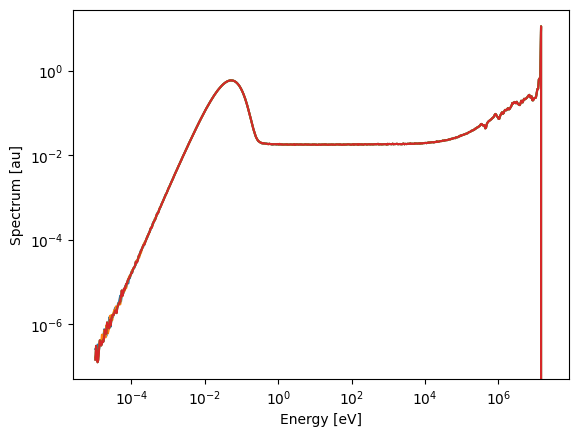

<Figure size 640x480 with 0 Axes>

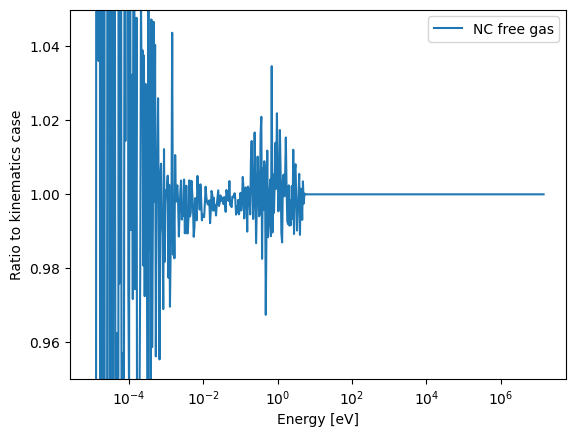

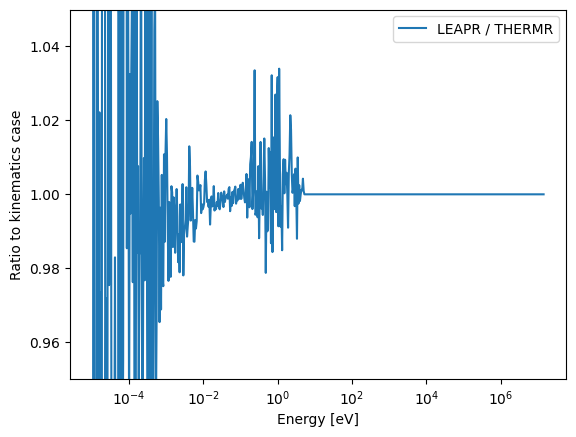

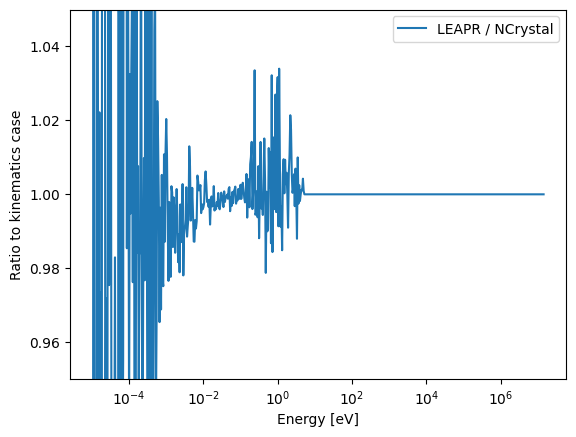

In [26]:
plt.loglog(E1,phi1)
plt.loglog(E2,phi2)
plt.loglog(E3,phi3)
plt.loglog(E4,phi4)
plt.xlabel('Energy [eV]')
plt.ylabel('Spectrum [au]')
plt.figure()
plt.figure()
plt.semilogx(E1, phi2/phi1, label='NC free gas')
plt.xlabel('Energy [eV]')
plt.ylabel('Ratio to kinematics case')
plt.legend()
plt.ylim(0.95, 1.05)
plt.figure()
plt.semilogx(E1, phi3/phi1, label='LEAPR / THERMR')
plt.xlabel('Energy [eV]')
plt.ylabel('Ratio to kinematics case')
plt.legend()
plt.ylim(0.95, 1.05)
plt.figure()
plt.semilogx(E1, phi4/phi1, label='LEAPR / NCrystal')
plt.xlabel('Energy [eV]')
plt.ylabel('Ratio to kinematics case')
plt.legend()
plt.ylim(0.95, 1.05)